### Introducción

Dentro del equipo de prevención de fraude de MercadoLibre nos enfrentamos diariamente a operaciones de tipo fraudulentas, es por eso mismo, que siendo un volumen tan masivo de transacciones debemos apoyarnos en la analítica de datos creando modelos matemáticos que nos permitan predecir a tiempo si un movimiento es de tipo fraude o no lo es.

Dentro de la inteligencia artificial hay diversas tecnologías que nos podemos apoyar para aforntar un problema de dicha índole. El aprendizaje automático (Machine Learning) nos permite a partir de experiencias pasadas tratar de inferir lo que va a suceder en el futuro.

Dentro del Machine Learning existe dos problemas fundamentales que se podrían clasificar de la siguiente manera:

**Aprendizaje no supervisado:** Los problemas de este tipo es cuando no tenemos una variable objetivo, sino que lo que buscamos es a partir de un conjunto de variables crear segmentos o grupos que se asemejen entre sí y sean lo más disímiles con los grupos restantes.  

**Aprendizaje supervisado:** Contrario a lo anterior cuando nos enfrentamos a un problema de este tipo sí tenemos una variable objetivo que queremos modelar o predecir a partir de otras variables predictoras.

Concretamente en el equipo de Fraude de MercadoLibre nos enfrentamos a un problema de clasificación binaria, en otras palabras, sí una transacción es fraude o no es fraude (1 o 0)

### Desarrollo

Todo el código para desarrollar el modelo será elaborado en Python 3 e inicialmente realizaremos una exploración de los datos para evitar la presencia de datos nulos o erróneos. Dejaremos una celda para la importación de las librerías, y posteriormente procederemos con la importación del dataset y el desarrollo del problema.

### Importación de las librerías

In [240]:
import pandas as pd 
import pandas_profiling
import numpy as np
from scipy import stats
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import time
warnings.filterwarnings("ignore")
%matplotlib inline

### Lectura del dataset

In [165]:
df = pd.read_csv('MercadoLibre.csv')

### Análisis de datos automático con Pandas-Profiling

Para simplificar el proceso de exploración de los datos usaremos pandas-profiling que nos crea un informe automático de los datos y nos permite visualizar fácilmente problemas o incongruencias en los datos

In [150]:
profile = pandas_profiling.ProfileReport(df)

In [151]:
profile

Number of variables,21
Number of observations,16880
Total Missing (%),4.5%
Total size in memory,2.7 MiB
Average record size in memory,168.0 B
Numeric,16
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


En la primera sección del informe se muestra información general del conjunto de datos. Posteriormente se muestra detalles de cada una de las características incluyendo el número de valores únicos, el número de nulos y estadísticos como valores máximos, mínimos y medias. Además de también se pueden encontrar secciones con datos de correlación y muestras de los datos.

En general se puede apreciar mucha presencia de ceros en las variables aunque eso no significa que el dato esté errado. Sin embargo, tenemos que realizar acciones sobre las siguientes variables:


**La variable C:** Tiene el 18.9% de sus datos vacíos, reemplazaremos ese dato con la mediana ya que la media se ve muy elevada con respecto a la mediana y la mediana es menos susceptible a datos atípicos.

In [166]:
df['C'].fillna(df['C'].median(), inplace=True)

**La variable K:** Tiene el 76.2% de sus datos vacíos, en este caso más de las tres cuartas partes de esta columna se encuentra vacías. Probablemente en este caso sea preferible no usar esta variable, de igual forma haremos la misma acción que con la variable C y estudiaremos si vale la pena incluir esta variable o no

In [167]:
df['K'].fillna(df['K'].median(), inplace=True)

**La variable J:** La variable J parece indicar el país de la transacción, sin embargo, hay 19 distintos países, pero sólo 3 albergan casi el 95% de la distribución de los datos. En este caso meteremos todas las categorías de países que no se encuentran en las 3 categorías predominantes (AR, BR, MX) en una sola categoría de otros países (OC)

In [168]:
cleanup_categories = {"J":  {'AU':'OC',
'CA':'OC',
'CH':'OC',
'CL':'OC',
'CO':'OC',
'ES':'OC',
'FR':'OC',
'GB':'OC',
'GT':'OC',
'IT':'OC',
'KR':'OC',
'PT':'OC',
'TR':'OC',
'UA':'OC',
'US':'OC',
'UY':'OC'}} 

df = df.replace(cleanup_categories)

**La variable Q:** Tiene una alta cardinalidad, eso supone que la variable es numérica pero se encuentra almacenada como texto. Ya que la variable tiene comas y puntos intermedios tendremos que realizar dos procesos

In [169]:
df['Q'] = df['Q'].str.replace(',', '').astype(float)

**La variable R:** Tiene una alta cardinalidad, eso supone que la variable es numérica pero se encuentra almacenada como texto. Ya que la variable tiene comas y puntos intermedios tendremos que realizar dos procesos

In [170]:
df['R'] = df['R'].str.replace(',', '').astype(float)

**La variable Monto:** Tiene una alta cardinalidad, eso supone que la variable es numérica pero se encuentra almacenada como texto.

In [171]:
df['Monto'] = df['Monto'].str.replace(',', '').astype(float)

**La variable Fraude:** La variable fraude se encuentra muy desbalanceada, el 27.3% de las filas corresponden a operaciones de fraude, más adelante tendremos que realizar un balanceo para corregir esto

In [172]:
df['Fraude'] = df['Fraude'].astype(int)

#### Correlación

En cuanto a los gráficos de correlación hay dos variables que se encuentran intímamente correlacionadas que son las variables K y B, y teniendo en cuenta que, la variable K además de que tiene muchos vacíos tiene una correlación tan fuerte que podría indicar multicolinealidad, es decir, que básicamente ofrecen la misma información.

Usaremos nuevamente pandas-profiling para ver que las correcciones que realizamos se aplicaron correctamente

In [159]:
profile = pandas_profiling.ProfileReport(df)

In [160]:
profile

Number of variables,21
Number of observations,16880
Total Missing (%),0.0%
Total size in memory,2.6 MiB
Average record size in memory,164.0 B
Numeric,19
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,0


Hay un registro duplicado pero al ser un sólo valor podría deberse a una mera casualidad, en caso de que el número de duplicados fuera un número considerable depuraríamos esto.

### Construcción del modelo sin balancear

Como mencionamos en la exploración de los datos la variable objetivo (Fraude) se encuentra muy desbalanceada en una proporción considerablemente grande. Probaremos diferentes algoritmos sin balancear y luego balancearemos el dataset con una estrategia de creación sintética de registros y ver si el performance del modelo mejora.

### Dummies variable categórica

Este procedimiento consiste en volver las variables categóricas en binarias ya que la mayoría de algoritmos no funcionan con variables tipo string (categóricas). Aquí cobra sentido la razón por la cual redujimos el número de categorías a 4 ya que si lo dejábamos tal cual se crearían tantas columnas como categorías existan, es decir, 19 columnas. Siempre se busca la simplicidad en los modelos.

In [173]:
# dummies variables categóricas
df = pd.get_dummies(df, columns=['J'])

### Normalización de los datos

Se entiende por normalizar transformar todas las variables a una misma escala con el fin de que el algoritmo no le dé relevancia a una variable que otra por ser una escala más grande. Normalizaremos todas las variables mayores que 1 puesto que, las que sean menores que 1 ya están implícitamente escaladas.

In [174]:
# Normalizar sólo columnas que tengan valores mayores que 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Reemplazar columnas con columnas normalizadas
for col in scaled:
    df[col] = scaled[col]


### División de set de entrenamiento y de prueba

En todo modelo de Machine Learning se debe partir el dataset mínimamente en dos partes una parte más grande con la que realizaremos el entrenamiento del modelo y una parte testing que sirve para evaluar el rendimiento del modelo. En este caso, lo dividiremos 80% y 20% (80% para entrenar y 20 % para probar)

In [184]:
# División variables predictoras (X) y variable objetivo (y)
X = df.drop('Fraude', axis=1)
y = df['Fraude']

# División set de entrenamiento y de testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Entrenamiento y evaluación de diferentes modelos sin balanceo de la variable objetivo

### Random Forest

Accuracy = 0.80
Recall = 0.42



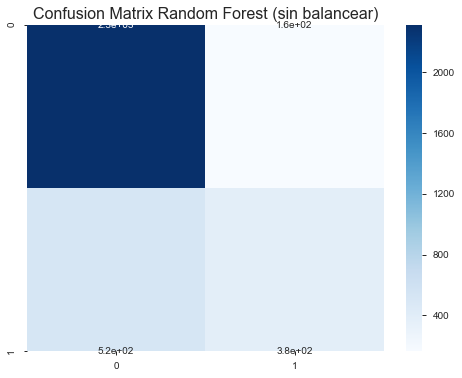

In [188]:
# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (sin balancear)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

La precisión del modelo del 80% pareciera indicar que la predicción es buena, sin embargo al ver el recall del 42% y la matriz de confusión parece indicar un caso de overfitting, está aprendiendo reglas para predecir operaciones de no fraude (0) y no de fraude (1) que es lo que realmente nos interesa. Este modelo no es usable.

### K vecinos más cercanos

Accuracy = 0.76
Recall = 0.41



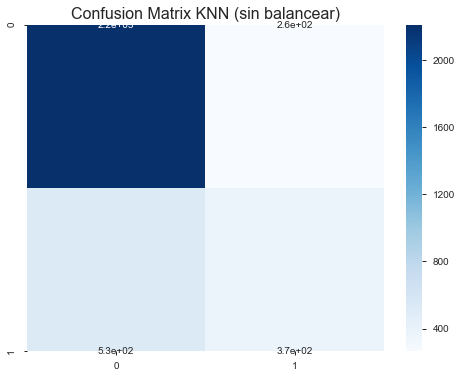

In [195]:
# Train
model = KNeighborsClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix KNN (sin balancear)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Este modelo funciona peor que el anterior, el accuracy y el recall son más bajos (76% y 41% respectivamente). No es usable

### XGBoost

[09:59:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.81
Recall = 0.46



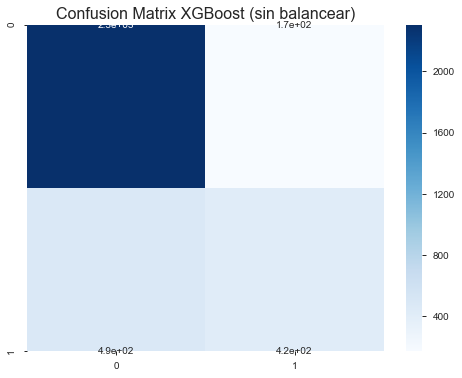

In [194]:
# Train
model = XGBClassifier(n_estimators=100)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix XGBoost (sin balancear)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

XGBoost parece funcionar ligeramente mejor que el Random Forest, sin embargo las predicciones de fraude siguen siendo deficientes.

### Support Vector Machine

Accuracy = 0.78
Recall = 0.25



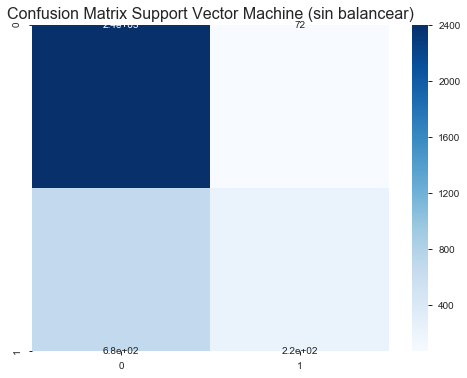

In [198]:
# Train
model = SVC()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Support Vector Machine (sin balancear)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

De todos los modelos es el de peor performance hasta el momento para nuestro conjunto de datos. Muy bajo recall

### Regresión Logística

Accuracy = 0.71
Recall = 0.68



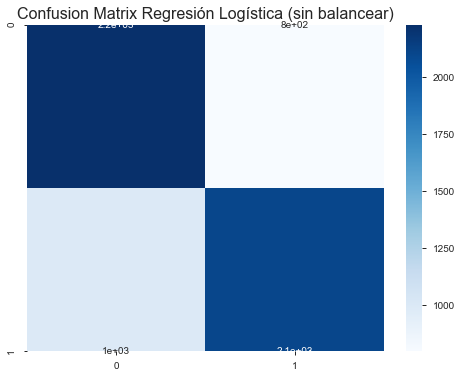

In [204]:
# Train
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Regresión Logística (sin balancear)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

La Regresión Logística muestra un rendimiento mucho mejor que el de los algoritmos anteriores. La precisión es más baja pero la predicción de Fraude es ostensiblmente mejor. El mejor modelo hasta el momento.

### Entrenamiento y evaluación de diferentes modelos balanceando la variable objetivo con SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) viene muy bien para nuestro caso. Puede usarlo para sobremuestrear la categoría minoritaria. SMOTE es un tipo de aumento de datos que sintetiza nuevas muestras a partir de las existentes. No es simplemente duplicar datos como comúnmente se hace, se crean datos nuevos.

In [202]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: Fraude, dtype: float64

Verificamos y efectivamente el balance de datos entre las clases es completamente equivalente y podríamos trabajar con un conjunto de datos mucho más consistente sin ventaja de ninguna clase sobre otra.

### División de set de entrenamiento y de prueba del set balanceado

In [224]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

### Entrenamiento y evaluación de diferentes modelos con balanceo de la variable objetivo

### Random Forest

Accuracy = 0.86
Recall = 0.84



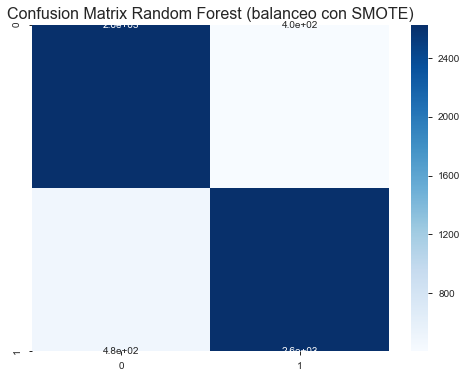

In [205]:
# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (balanceo con SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Los resultados del modelo comparados con su versión no balanceada son increíblemente superiores. Tanto su recall como su precisión tienen valores muy positivos (84% y 86%). Un modelo con gran performance y que podría usarse en entornos productivos.

### K vecinos más cercanos

Accuracy = 0.78
Recall = 0.85



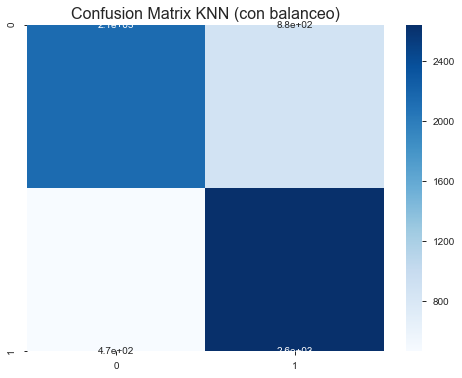

In [206]:
# Train
model = KNeighborsClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix KNN (con balanceo)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Los resultados de este modelo son buenos pero inferiores a los del Random Forest. Las predicciones de fraude se incrementaron pero sacrificando por falsos positivos. La precisión bajó con respecto al anterior.

### XGBoost

[10:14:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.85
Recall = 0.82



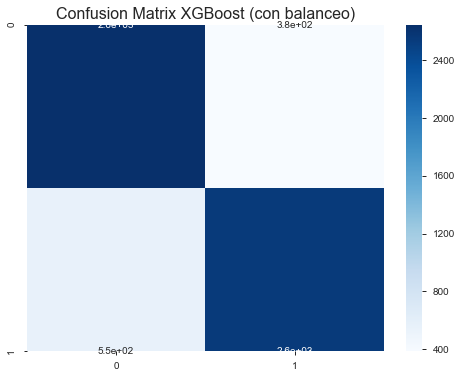

In [207]:
# Train
model = XGBClassifier(n_estimators=100)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix XGBoost (con balanceo)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Los resultados del XGBoost son muy similares pero ligeramente inferiores a los del Random Forest intetaremos tunear los hiperparámetros e intentar mejorar su performance.

### Support Vector Machine

Accuracy = 0.70
Recall = 0.72



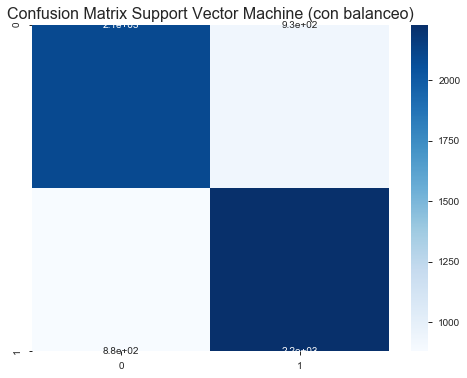

In [208]:
# Train
model = SVC()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Support Vector Machine (con balanceo)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Resultados positivos del SVC pero ampliamente superado por Random Forest y XGBoost

### Regresión Logística

Accuracy = 0.71
Recall = 0.68



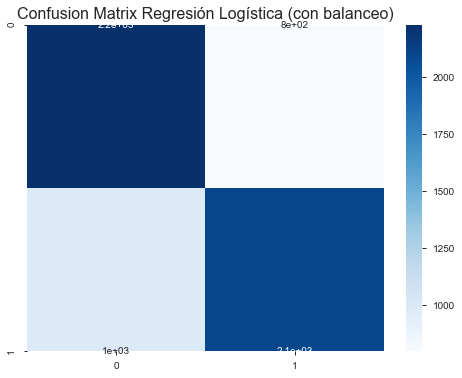

In [209]:
# Train
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Regresión Logística (con balanceo)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

La Regresión Logística no mostró mejoría con respecto a su versión no balanceada. De los modelos uno de los más bajo rendimiento.

### Tuning de hiperparámetros

Los mejores modelos sin cambiar sus hiperparámetros fueron el Random Forest y el XGBoost, por tanto, usaremos la estrategia de GridSearch buscando los hiperparámetros óptimos que mejoren el rendimiento de ambos modelo y escoger el mejor entre ambos.

Iniciaremos con el tuning del XGBoost y posteriormente finalizaremos con el Random Forest

### XGBoost tuning

Necesitamos especificar una función objetivo. En este caso usamos “binary:logistic” función porque entrenamos un modelo de clasificación que maneja sólamente dos clases.

In [210]:
# Especificamos la función objetivo
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

En el siguiente paso, especificamos los hiperparámetros tuneables y su rango de valores.

In [267]:
# Especificamos los rangos de parámetros tuneables
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

En el último paso configuramos el GridSearch. Los mejores hiperparámetros saldrán usando ROC_AUC como métrica para comparar 10-fold cross-validation (10 chequeos de validación cruzada)

In [214]:
# GridSearch con 10-fold cross-validation
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

Ahora podemos hacer el entrenamiento 


**SE RECOMIENDA NO VOLVER A CORRER ESTA CELDA, 25-30 MINS DE EJECUCIÓN**

In [219]:
grid_search.fit(X_sm, y_sm)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[10:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

El best_estimator_ contiene el mejor modelo entrenado por GridSearchfield.

In [220]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Finalmente ejecutamos nuestro nuevo modelo XGBoost tuneado y comparamos resultados con su versión no tuneada

[11:51:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.85
Recall = 0.83



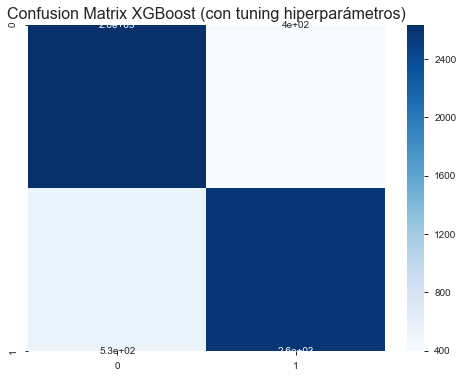

In [234]:
# Train
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix XGBoost (con tuning hiperparámetros)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Si comparamos XGBoost sin tuneo (85% precisión y 82% recall) y XGBoost (85% precisión y 83% recall) la mejoría fue muy leve, casi imperceptible. Aún así es un buen modelo pero no mejor que nuestro mejor modelo hasta hora Random Forest (86% precisión y 84% recall)

### Random Forest tuning

Análogo al XGBoost usaremos GridSearch con una lista de hiperparámetros y veremos si su performance es mejor

**SE RECOMIENDA NO VOLVER A CORRER ESTA CELDA, 25-30 MINS DE EJECUCIÓN**

In [226]:
# Inicializamos nuestro Random Forest
forest = RandomForestClassifier(random_state = 1)

# Especificamos los rangos de parámetros tuneables
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

# GridSearch
gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

# Realizamos el entrenamientos
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [231]:
# Contienen los mejores hiperparámetros del GridSearch
bestF.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)

Finalmente ejecutamos nuestro nuevo modelo Random Forest tuneado y comparamos resultados con su versión no tuneada

Accuracy = 0.85
Recall = 0.85



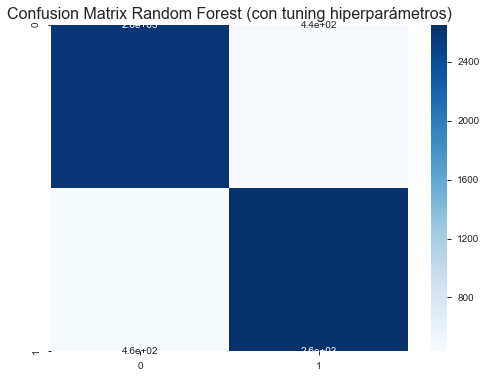

In [268]:
# Train
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Si comparamos los 4 mejores modelos tienen resultados muy similares:
* XGBoost sin tuning: 85% precisión y 82% recall
* XGBoost con tuning: 85% precisión y 83% recall
* Random Forest sin tuning: 86% precisión y 84% recall
* Random Forest con tuning: 85% precisión y 85% recall

Escogeremos el Random Forest con tuning y dataset balanceado como nuestro modelo ganador y es el que llevaremos a producción.

### Feature Selection

Ya llegando al final queremos depurar nuestro modelo y encontrar el modelo más óptimo y eficiente, por ello usaremos la técnica Recursive Feature Elimination que lo que hace es estimar coeficientes para cada una de las variables y rankear su importancia para el modelo. 

Lo que haré es una especie de eliminatoria de abajo hacia arriba donde iré incrementando una a una cada variable según el ranking e ir mirando paralelamente sus métricas hasta el punto en que no haya ganancia de información y escoger el número de variables óptimas para el modelo

**SE RECOMIENDA NO EJECUTAR LAS CELDAS DEL FEATURE SELECTION, ALREDEDOR de 10-15 MINS DE EJECUCIÓN POR CADA CELDA**

Accuracy = 0.74
Recall = 0.75



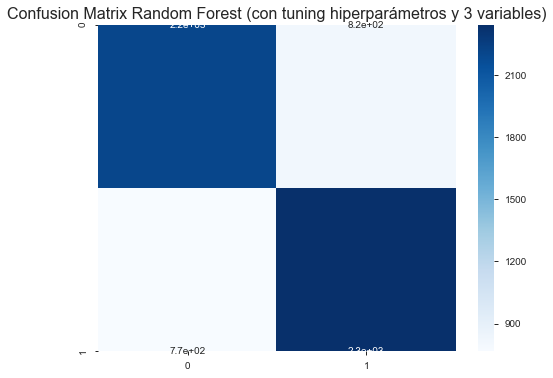

In [249]:
# Inicializamos nuestro modelo ganador con 3 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 3)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 3 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.77
Recall = 0.79



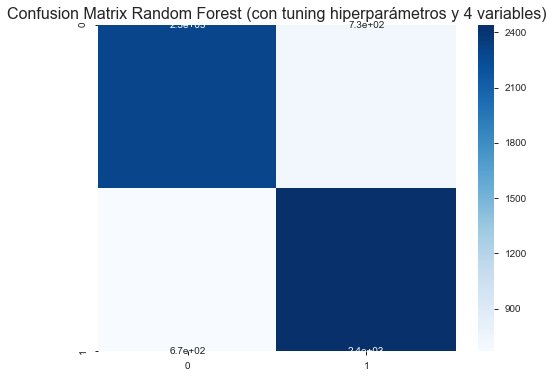

In [250]:
# Inicializamos nuestro modelo ganador con 4 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 4)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 4 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.79
Recall = 0.79



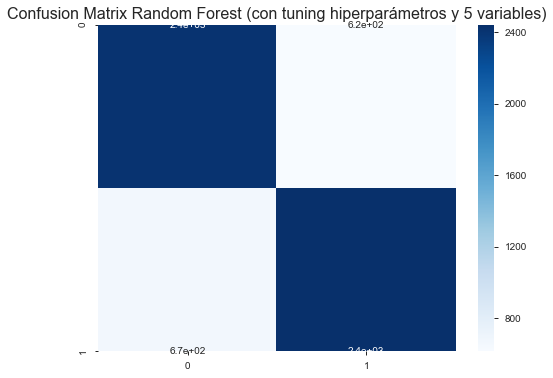

In [251]:
# Inicializamos nuestro modelo ganador con 5 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 5)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 5 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.80
Recall = 0.80



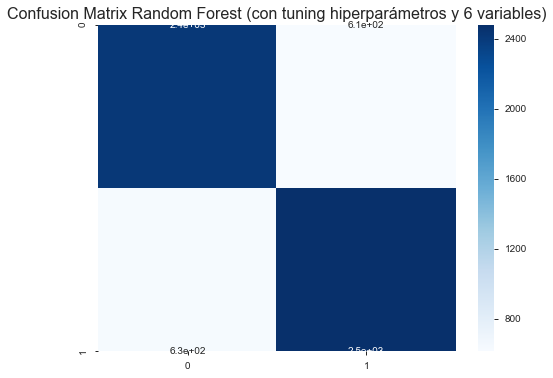

In [252]:
# Inicializamos nuestro modelo ganador con 6 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 6)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 6 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.82
Recall = 0.81



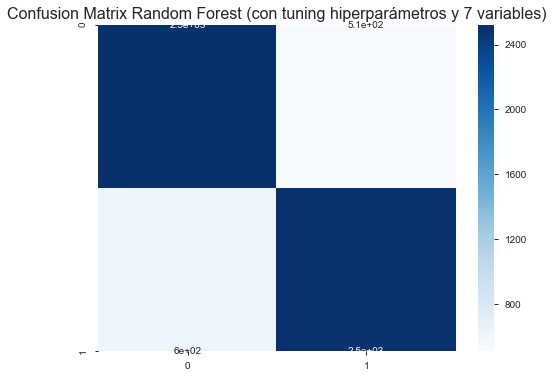

In [253]:
# Inicializamos nuestro modelo ganador con 7 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 7)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 7 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.83
Recall = 0.81



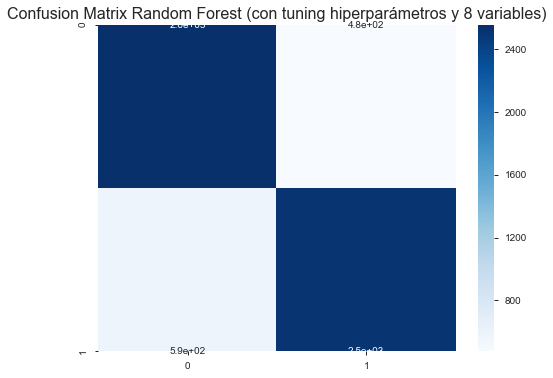

In [254]:
# Inicializamos nuestro modelo ganador con 8 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 8)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 8 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.83
Recall = 0.82



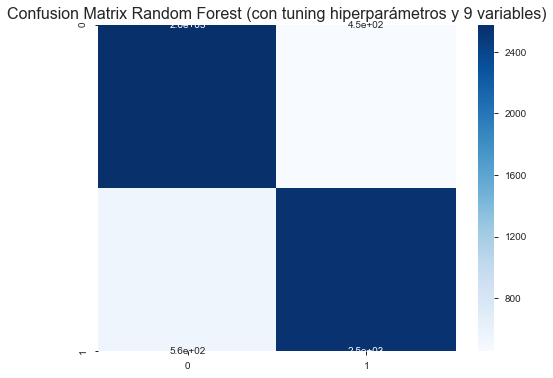

In [255]:
# Inicializamos nuestro modelo ganador con 9 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 9)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 9 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.83
Recall = 0.83



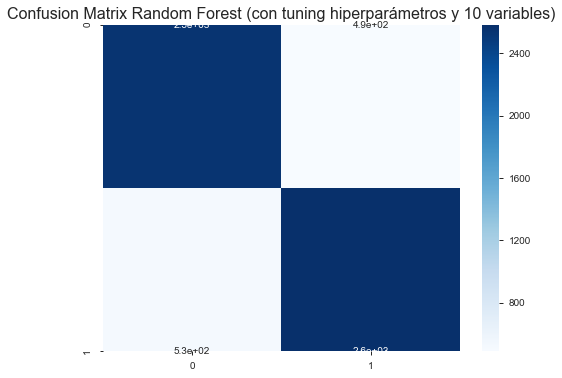

In [256]:
# Inicializamos nuestro modelo ganador con 10 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 10)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 10 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.84
Recall = 0.83



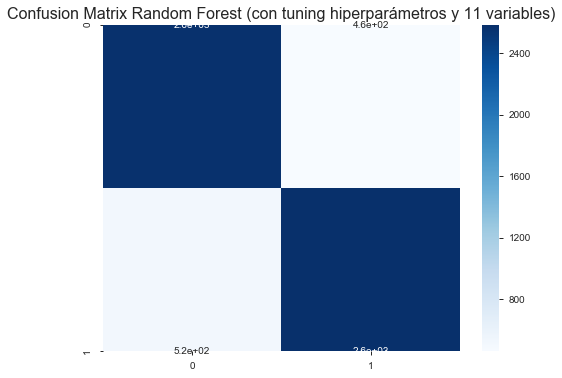

In [257]:
# Inicializamos nuestro modelo ganador con 11 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 11)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 11 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.84



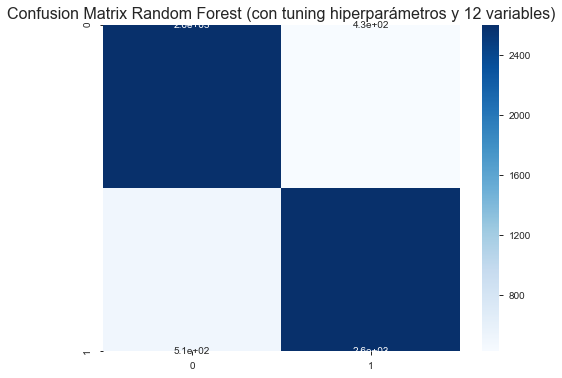

In [258]:
# Inicializamos nuestro modelo ganador con 12 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 12)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 12 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.84



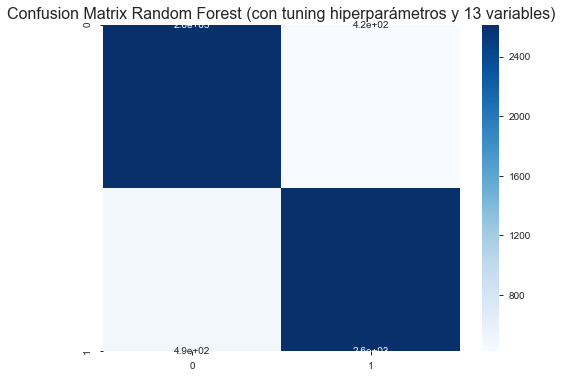

In [259]:
# Inicializamos nuestro modelo ganador con 13 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 13)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 13 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.85



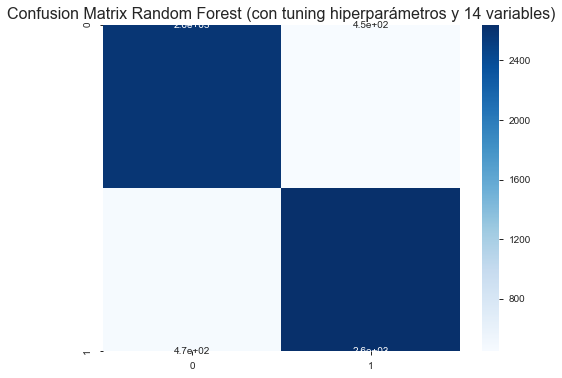

In [271]:
# Inicializamos nuestro modelo ganador con 14 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 14)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 14 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.85



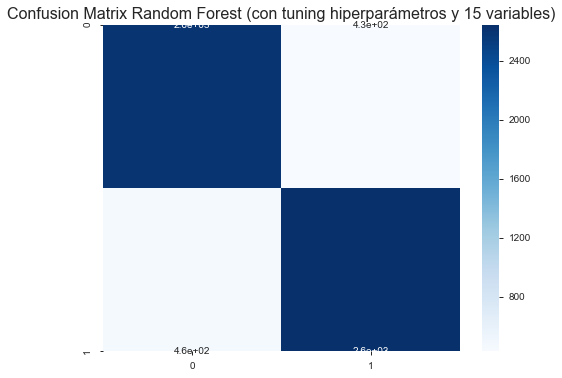

In [261]:
# Inicializamos nuestro modelo ganador con 15 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 15)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 15 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.85



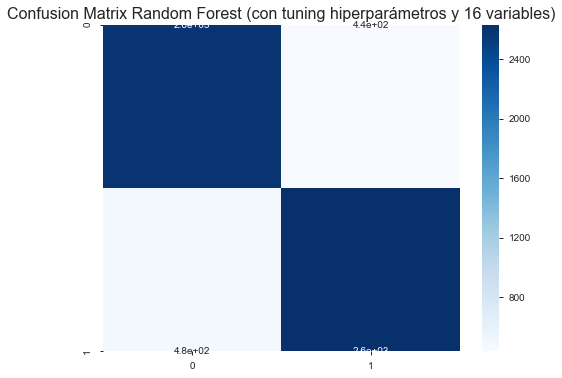

In [263]:
# Inicializamos nuestro modelo ganador con 16 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 16)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 16 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.85



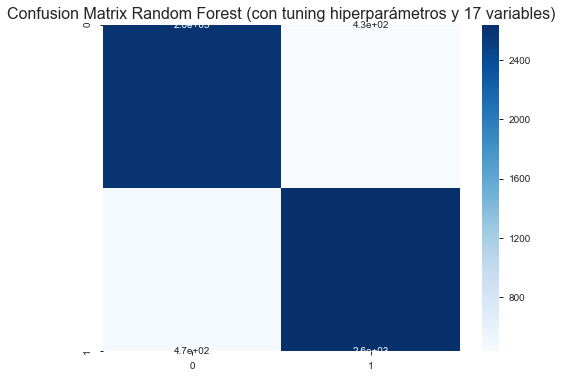

In [264]:
# Inicializamos nuestro modelo ganador con 17 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 17)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 17 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Accuracy = 0.85
Recall = 0.85



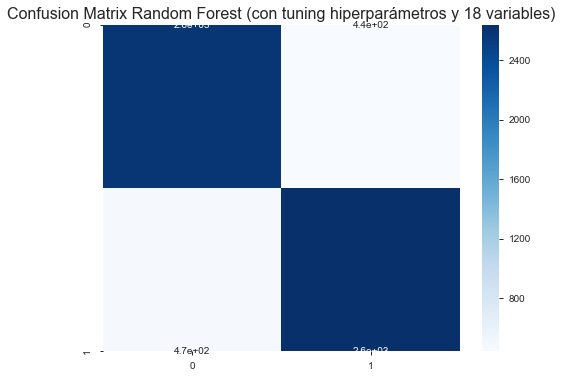

In [265]:
# Inicializamos nuestro modelo ganador con 18 variables
model = RandomForestClassifier(max_depth=30, n_estimators=800, random_state=1)
rfe = RFE(model, 18)
fit = rfe.fit(X_train, y_train)
preds = fit.predict(X_test)

# Evaluación
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest (con tuning hiperparámetros y 18 variables)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

.

Se puede concluir que el modelo óptimo sería con 14 variables después de incluir la decimoquinta variable no hubo mejoría considerable en las métricas, este sería nuestro mejor modelo encontrado finalmente. 

### Conclusiones

* Para lograr un buen modelo es sumamente importante la exploración inicial de los datos evitando errores de calidad de los mismos.
* Es importante probar diferentes algoritmos, en ocasiones algunos tienen mejor performance que otros según el conjunto de datos.
* Se pudo apreciar la vital importancia de balancear la variable objetivo, el performance de los modelos se incrementó abruptamente y nos dejó un modelo bastante satisfactorio.
* SMOTE como técnica de balanceo es muy útil y fácil de implementar nos crea observaciones sintéticas de la clase desbalanceada.
* La simplicidad es importante, un Random Forest como modelo doblegó a un XGBoost, tanto en performance como en tiempo de ejecución (Navaja de Ockam)

### Autor

Andrés Grisales Ardila